# *Scraping* [Kabupaten Kepahiang](https://covid19.bengkuluprov.go.id/Databengkulu)

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import re
import time
from datetime import datetime as dt
from selenium import webdriver

options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver',options=options)

In [2]:
url = 'https://covid19.bengkuluprov.go.id/Databengkulu'
driver.get(url)
time.sleep(2)
content = driver.page_source
soup = BeautifulSoup(content, "html.parser")

In [3]:
div = soup.find('table', id = 'example')

In [4]:
# Tanggal Update 
tgl = div.findAll('td')
date = tgl[1].text
now = dt.now().strftime('%Y-%m-%d')

In [5]:
# Click Link PDF Update Kasus Pada Website
div2 = div.find('a').get('href')
div2

'https://covid19.bengkuluprov.go.id/Databengkulu/filepdf/438'

In [6]:
driver2 = webdriver.Chrome('chromedriver',options=options)
url2 = div2
driver2.get(url2)
time.sleep(5)
content2 = driver2.page_source 

In [7]:
soup2 = BeautifulSoup(content2, "html.parser")
pdf_link = soup2.findAll('iframe')[0].get('src')
pdf_link

'https://covid19.bengkuluprov.go.id/asset/web/assets/pdf/PRESS_RELEASE_COVID-19,_17_OKTO_2021.pdf'

In [8]:
import urllib.request
pdf_path = pdf_link
def download_file(download_url, filename):
    response = urllib.request.urlopen(download_url)    
    file = open(filename, 'wb')
    file.write(response.read())
    file.close()
 
download_file(pdf_path, "!KepahiangKabDownloadPDF.pdf")

In [9]:
import fitz

pdffile = "!KepahiangKabDownloadPDF.pdf"
doc = fitz.open(pdffile)
page = doc.loadPage(1)  # number of page
pix = page.getPixmap()
output = "!KepahiangKabConvertToPNG.png"
pix.writePNG(output)

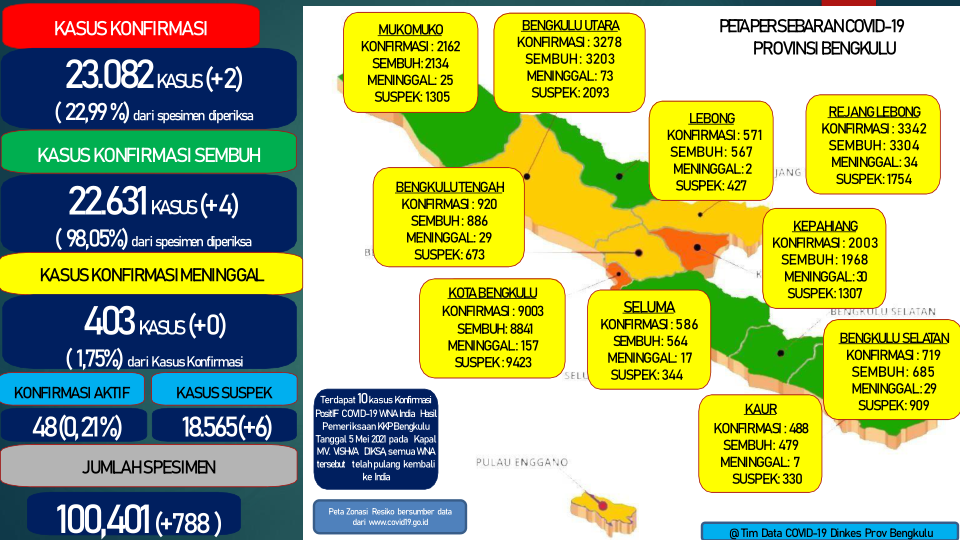

In [10]:
from PIL import Image
import requests

pil_image = Image.open(output)
pil_image

In [11]:
# Crop the iceberg portion
gambar_data = pil_image.crop((845,233,885,253))
gambar_data2 = pil_image.crop((839,248,880,270))
gambar_data3 = pil_image.crop((860,265,880,286))

gambar_data2

In [12]:
gambar_data = gambar_data.save("!KepahiangKab_data.png")
gambar_data2 = gambar_data2.save("!KepahiangKab_data2.png")
gambar_data3 = gambar_data3.save("!KepahiangKab_data3.png")

In [13]:
import easyocr

reader = easyocr.Reader(['id','en'], gpu=False)
hasil_1 = reader.readtext('!KepahiangKab_data.png')
hasil_2 = reader.readtext('!KepahiangKab_data2.png')
hasil_3 = reader.readtext('!KepahiangKab_data3.png')

Using CPU. Note: This module is much faster with a GPU.


In [14]:
# Cleansing Tuple to required data only

up = []
for i in range(len(hasil_1)):
    up.append(hasil_1[i][1])

mid = []
for z in range(len(hasil_2)):
    mid.append(hasil_2[z][1])

down = []
for z in range(len(hasil_3)):
    down.append(hasil_3[z][1])

In [15]:
data1 = []
for x in range(len(up)):
    data1.append(up[x].replace('.',''))
data2 = []
for x in range(len(mid)):
    data2.append(mid[x].replace('.',''))
data3 = []
for x in range(len(down)):
    data3.append(down[x].replace('.',''))

data1, data2, data3

(['2003'], ['1968'], [])

In [16]:
pos = data1[0]
sem = data2[0]
mng = '30'#data3[0] MANUAL WARNING!!!!!!!!

In [17]:
scrape_date = [now]
date_update = [date]
provinsi = []
kabkot = []
kecamatan = []
kelurahan = []
total_positif = [pos]
positif_sembuh = [sem]
positif_meninggal = [mng]
types = []
source_link = [url]
user_pic = []

In [18]:
df = pd.DataFrame()
df ['scrape_date'] = scrape_date
df ['date_update'] = date_update
df.insert(2,column='provinsi', value = 'Bengkulu')
df.insert(3,column='kabkot', value = 'Kabupaten Kepahiang')
df.insert(4,column='kecamatan', value = '-')
df.insert(5,column='kelurahan', value = '-')
df ['total_positif'] = total_positif
df ['positif_sembuh'] = positif_sembuh
df ['positif_meninggal'] = positif_meninggal
df ['source_link'] = source_link
df.insert(10,column='types', value = 'Kabupaten')
df.insert(11,column='user_pic', value = 'Wahyu')
df

,scrape_date,date_update,provinsi,kabkot,kecamatan,kelurahan,total_positif,positif_sembuh,positif_meninggal,source_link,types,user_pic
0,2021-10-18,2021-10-17,Bengkulu,Kabupaten Kepahiang,-,-,2003,1968,30,https://covid19.bengkuluprov.go.id/Databengkulu,Kabupaten,Wahyu


In [19]:
import mysql.connector
from mysql.connector import errorcode
from sqlalchemy import create_engine

try:
    mydb = mysql.connector.connect(host='db-blanja2',
                                      port=3306,
                                 user='covid_user',
                                 passwd='5bb6593aa078',
                                 database='covid')
    cursor = mydb.cursor()
    cols2 = "`,`".join([str(i) for i in df.columns.tolist()])
    # Insert DataFrame records one by one. 
    for i,row in df.iterrows():
        sql = "INSERT INTO `covid19_data` (`" +cols2 + "`) VALUES (" + "%s,"*(len(row)-1) + "%s)" 
        cursor.execute(sql, tuple(row)) 
        # the connection is not autocommitted by default, so we must commit to save our # changes 
        mydb.commit()

except mysql.connector.Error as error:
    print("Failed to insert into MySQL table {}".format(error))

finally:
    if (mydb.is_connected()):
        cursor.close()
        mydb.close()
        print("Kabupaten Kepahiang Done " + date)

Kabupaten Kepahiang Done 2021-10-17
